In [1]:
import numpy as np
import matplotlib.pyplot as plt, pandas as pd, seaborn as sns
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score as siluet
from sklearn.metrics.cluster import homogeneity_score as purity
from sklearn.metrics import normalized_mutual_info_score as NMI 

meta = pd.read_csv('building_metadata.csv',sep=',')
samplesub = pd.read_csv('sample_submission.csv',sep=',')
test = pd.read_csv('test.csv',sep=',')
train = pd.read_csv('train.csv',sep=',')
wtrain = pd.read_csv('weather_train.csv',sep=',')
wtest = pd.read_csv('weather_test.csv',sep=',')

#train.csv

##building_id - Foreign key for the building metadata.

##meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.

##timestamp - When the measurement was taken

##meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.


building_meta.csv

site_id - Foreign key for the weather files.

building_id - Foreign key for training.csv

primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions

square_feet - Gross floor area of the building

year_built - Year building was opened

floor_count - Number of floors of the building


weather_[train/test].csv

Weather data from a meteorological station as close as possible to the site.

site_id

air_temperature - Degrees Celsius

cloud_coverage - Portion of the sky covered in clouds, in oktas

dew_temperature - Degrees Celsius

precip_depth_1_hr - Millimeters

sea_level_pressure - Millibar/hectopascals

wind_direction - Compass direction (0-360)

wind_speed - Meters per second


test.csv
The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

row_id - Row id for your submission file

building_id - Building id code

meter - The meter id code

timestamp - Timestamps for the test data period


sample_submission.csv
A valid sample submission.

All floats in the solution file were truncated to four decimal places; we recommend you do the same to save space on your file upload.
There are gaps in some of the meter readings for both the train and test sets. Gaps in the test set are not revealed or scored.

In [2]:
meta.sample(20)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
357,3,357,Lodging/residential,2000,NaN,NaN
320,3,320,Education,105500,NaN,NaN
252,2,252,Education,4314,1907.0,NaN
1048,12,1048,Education,275610,NaN,NaN
1363,15,1363,Office,157933,1932.0,NaN
194,2,194,Office,155682,NaN,NaN
527,3,527,Public services,9392,NaN,NaN
443,3,443,Education,109000,1940.0,NaN
204,2,204,Lodging/residential,30949,1951.0,NaN
693,5,693,Office,57436,1976.0,3.0


In [3]:
samplesub.sample(20) #skip

,row_id,meter_reading
18081482,18081482,0
6196149,6196149,0
13646961,13646961,0
24882739,24882739,0
5628132,5628132,0
40101765,40101765,0
19448461,19448461,0
39928762,39928762,0
19539705,19539705,0
39636776,39636776,0


In [4]:
test.sample(10)

,row_id,building_id,meter,timestamp
20124773,20124773,889,2,2017-03-04 22:00:00
8928647,8928647,557,0,2017-03-20 12:00:00
5586652,5586652,181,0,2017-11-19 14:00:00
41545306,41545306,793,0,2017-03-20 06:00:00
14829463,14829463,657,0,2017-01-12 00:00:00
18551262,18551262,866,0,2017-03-10 01:00:00
15626223,15626223,689,0,2018-01-20 15:00:00
28830396,28830396,1212,1,2017-10-09 19:00:00
23371846,23371846,929,2,2018-05-21 13:00:00
33674042,33674042,1317,0,2017-08-08 23:00:00


In [5]:
train.sample(20)

,building_id,meter,timestamp,meter_reading
13366472,755,0,2016-09-01 03:00:00,14.2167
18224175,1133,1,2016-11-26 07:00:00,0.0000
12340462,181,0,2016-08-13 18:00:00,204.6300
7773395,127,0,2016-05-24 06:00:00,15.7500
7773749,337,0,2016-05-24 06:00:00,53.9900
16840921,330,0,2016-11-01 17:00:00,79.1300
12219224,908,1,2016-08-11 12:00:00,612.1080
12418999,276,0,2016-08-15 05:00:00,191.8100
17606205,130,0,2016-11-15 08:00:00,36.2000
2813597,507,0,2016-02-22 04:00:00,30.2200


In [6]:
wtrain.sample(10)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
126676,14,2016-06-21 13:00:00,25.0,0.0,17.2,0.0,1009.9,320.0,4.6
120109,13,2016-09-21 14:00:00,18.3,NaN,15.6,0.0,1016.9,60.0,5.1
95088,10,2016-11-07 17:00:00,12.2,0.0,2.2,0.0,1026.4,40.0,4.6
45106,5,2016-02-21 02:00:00,9.0,NaN,9.0,NaN,NaN,250.0,9.8
14992,1,2016-09-16 09:00:00,15.9,NaN,14.2,NaN,1011.1,310.0,6.2
20556,2,2016-05-05 09:00:00,25.0,0.0,-1.7,0.0,1007.6,130.0,2.6
133099,15,2016-03-19 15:00:00,-1.1,0.0,-8.9,NaN,1023.0,300.0,3.1
104318,11,2016-12-02 16:00:00,3.4,NaN,1.0,NaN,1005.2,280.0,4.6
18525,2,2016-02-10 18:00:00,23.9,2.0,-4.4,0.0,1022.2,80.0,6.2
86438,9,2016-11-13 05:00:00,16.7,0.0,12.8,0.0,1023.2,30.0,2.6


In [7]:
wtest.sample(10)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
125655,7,2017-06-06 06:00:00,12.6,NaN,11.5,29.0,1007.9,70.0,7.2
108093,6,2017-05-26 14:00:00,21.7,0.0,11.7,0.0,1008.3,270.0,3.6
182423,10,2018-01-01 02:00:00,-2.2,0.0,-8.9,0.0,1027.9,0.0,0.0
132714,7,2018-04-12 02:00:00,1.1,NaN,-0.6,NaN,1015.3,210.0,1.5
107600,6,2017-05-06 01:00:00,21.1,0.0,11.7,0.0,993.7,210.0,4.6
103569,5,2018-11-12 19:00:00,11.0,NaN,7.0,NaN,NaN,220.0,7.7
142393,8,2017-06-04 19:00:00,28.3,NaN,22.2,-1.0,1014.0,NaN,1.5
249391,14,2017-10-14 02:00:00,16.7,NaN,15.0,0.0,1025.9,60.0,2.6
59009,3,2017-10-06 11:00:00,18.9,NaN,16.7,0.0,1020.2,190.0,2.1
98598,5,2018-04-15 08:00:00,9.0,NaN,9.0,NaN,NaN,130.0,6.7


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [9]:
train.shape

(20216100, 4)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   row_id       int64 
 1   building_id  int64 
 2   meter        int64 
 3   timestamp    object
dtypes: int64(3), object(1)
memory usage: 1.2+ GB


In [11]:
test.shape

(41697600, 4)

In [12]:
df = train.loc[train['meter']==0]
df.sample(20)

,building_id,meter,timestamp,meter_reading
533667,1177,0,2016-01-10 16:00:00,35.9940
15166474,192,0,2016-10-03 00:00:00,686.7300
11202360,775,0,2016-07-24 04:00:00,146.6670
14640007,1074,0,2016-09-23 16:00:00,105.9430
19735329,841,0,2016-12-23 12:00:00,0.0000
16289830,447,0,2016-10-22 21:00:00,39.5200
2879450,146,0,2016-02-23 12:00:00,19.6000
129027,236,0,2016-01-03 08:00:00,42.3600
11672760,435,0,2016-08-01 15:00:00,102.4300
15010658,178,0,2016-09-30 06:00:00,26.9200


In [13]:
df.drop(['timestamp'],axis = 1, inplace = True)
df

C:\Users\Andri\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,building_id,meter,meter_reading
0,0,0,0.000
1,1,0,0.000
2,2,0,0.000
3,3,0,0.000
4,4,0,0.000
...,...,...,...
20216095,1444,0,8.750
20216096,1445,0,4.825
20216097,1446,0,0.000
20216098,1447,0,159.575


In [14]:
meta.shape

(1449, 6)

In [15]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [16]:
new = df.join(meta, on='building_id', how= 'inner', lsuffix='a', rsuffix='b')

In [17]:
new.drop(['building_ida', 'building_idb', 'meter'], axis = 1, inplace = True)

In [18]:
new

,building_id,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0.00,0,Education,7432,2008.0,NaN
2301,0,0.00,0,Education,7432,2008.0,NaN
4594,0,0.00,0,Education,7432,2008.0,NaN
6893,0,0.00,0,Education,7432,2008.0,NaN
9189,0,0.00,0,Education,7432,2008.0,NaN
...,...,...,...,...,...,...,...
20204864,403,43.66,3,Education,49500,1962.0,NaN
20207227,403,43.64,3,Education,49500,1962.0,NaN
20209593,403,43.89,3,Education,49500,1962.0,NaN
20211958,403,44.37,3,Education,49500,1962.0,NaN


In [19]:
tes = new.loc[new['floor_count']==1]
tes.sample(20)

,building_id,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
18171480,700,15.0000,5,Education,11464,1976.0,1.0
9648065,670,11.9000,5,Healthcare,18471,1966.0,1.0
14301436,1051,9.3550,12,Education,28406,NaN,1.0
13392300,665,0.4200,5,Entertainment/public assembly,8773,1966.0,1.0
4103125,867,179.1670,8,Public services,65913,NaN,1.0
9702103,823,98.3333,8,Public services,35253,NaN,1.0
5323852,865,20.0000,8,Public services,10174,NaN,1.0
11200105,807,2.1250,8,Entertainment/public assembly,3000,NaN,1.0
8890907,1001,6.0000,10,Other,4482,NaN,1.0
1323870,823,135.0000,8,Public services,35253,NaN,1.0


In [20]:
new['floor_count'] = new['floor_count'].fillna(0)
new.head()

,building_id,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0.0,0,Education,7432,2008.0,0.0
2301,0,0.0,0,Education,7432,2008.0,0.0
4594,0,0.0,0,Education,7432,2008.0,0.0
6893,0,0.0,0,Education,7432,2008.0,0.0
9189,0,0.0,0,Education,7432,2008.0,0.0


In [21]:
new.describe()

,building_id,meter_reading,site_id,square_feet,year_built,floor_count
count,1.206091e+07,1.206091e+07,1.206091e+07,1.206091e+07,5.590875e+06,1.206091e+07
mean,7.066480e+02,1.708256e+02,6.749956e+00,9.271431e+04,1.968335e+03,9.336485e-01
std,4.152330e+02,3.808343e+02,4.946888e+00,1.121100e+05,3.101556e+01,2.337107e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,0.000000e+00
25%,3.450000e+02,1.950000e+01,3.000000e+00,2.301200e+04,1.950000e+03,0.000000e+00
50%,6.980000e+02,6.283190e+01,5.000000e+00,5.781100e+04,1.970000e+03,0.000000e+00
75%,1.063000e+03,1.700750e+02,1.200000e+01,1.161210e+05,1.996000e+03,0.000000e+00
max,1.448000e+03,7.976900e+04,1.500000e+01,8.750000e+05,2.017000e+03,2.600000e+01


In [22]:
new.isnull().sum()

building_id            0
meter_reading          0
site_id                0
primary_use            0
square_feet            0
year_built       6470035
floor_count            0
dtype: int64

In [23]:
new = new.sample(150000)

C:\Users\Andri\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Andri\anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


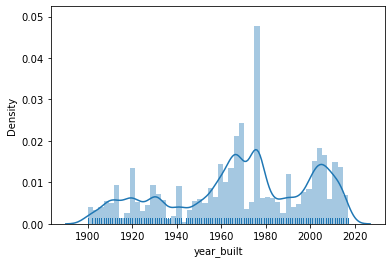

In [24]:
p = sns.distplot(new['year_built'], kde=True, rug=True)

In [25]:
new['year_built'] = new['year_built'].fillna(new['year_built'].mean())
new.head()

,building_id,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
7833034,1288,624.534,14,Education,164206,1968.306625,0.0
10383307,576,142.500,4,Education,86465,2014.000000,7.0
6241047,161,4.400,2,Education,11329,1968.306625,0.0
12385565,490,283.090,3,Education,98900,1961.000000,0.0
12955041,1446,10.475,15,Entertainment/public assembly,11265,1997.000000,0.0


               building_id  meter_reading   site_id  square_feet  year_built  \
building_id       1.000000       0.019190  0.976728     0.085085   -0.160597   
meter_reading     0.019190       1.000000  0.024513     0.566235    0.080945   
site_id           0.976728       0.024513  1.000000     0.091963   -0.120017   
square_feet       0.085085       0.566235  0.091963     1.000000    0.077162   
year_built       -0.160597       0.080945 -0.120017     0.077162    1.000000   
floor_count      -0.152437       0.196089 -0.201882     0.110530   -0.111485   

               floor_count  
building_id      -0.152437  
meter_reading     0.196089  
site_id          -0.201882  
square_feet       0.110530  
year_built       -0.111485  
floor_count       1.000000  


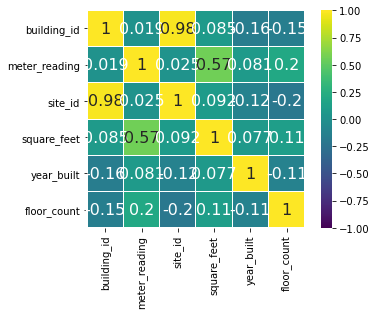

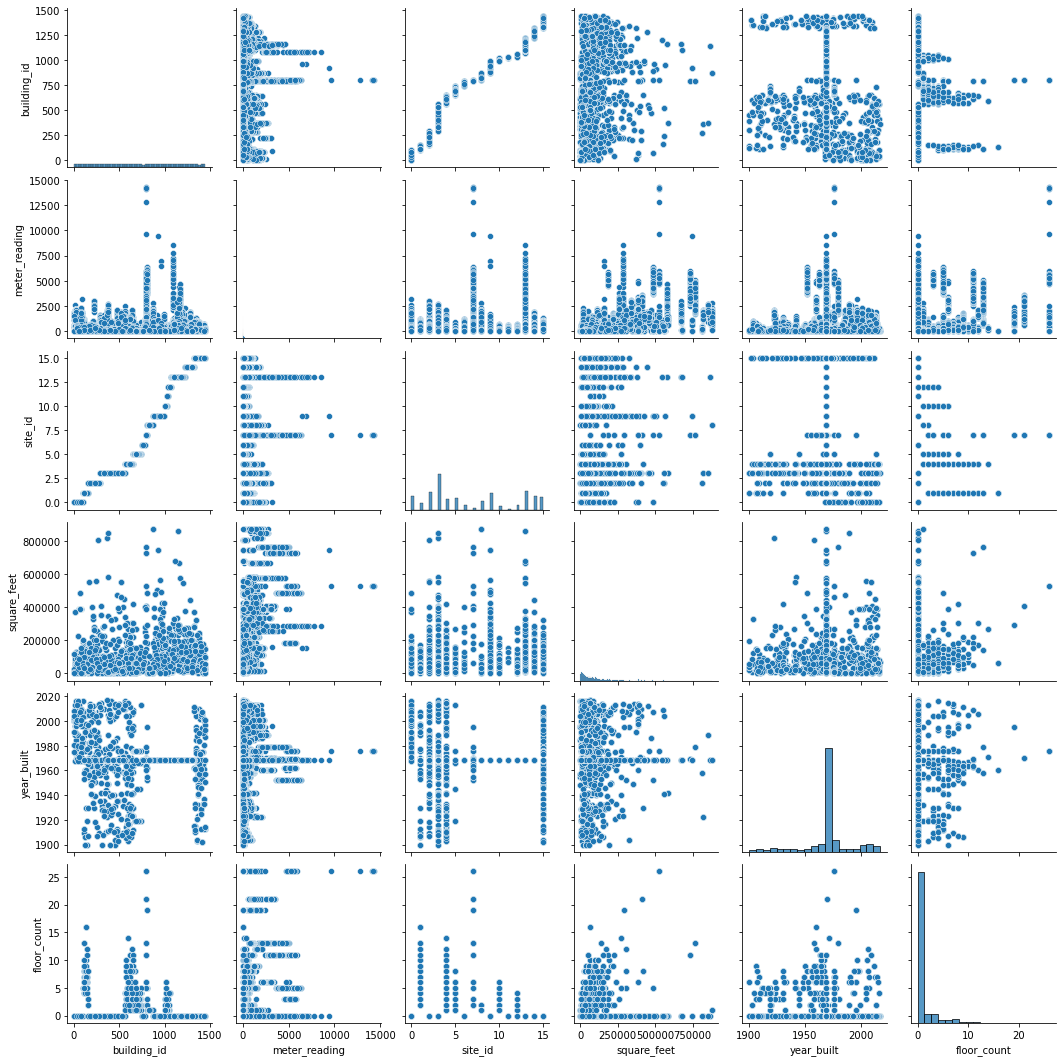

In [26]:
print(new.corr())
sns.heatmap(new.corr(),cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,annot=True,
annot_kws={"size": 16}, square=True)
p = sns.pairplot(new)
p

In [27]:
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.api as sm, scipy.stats as stats
lm = smf.ols("meter_reading ~ square_feet + floor_count + year_built", data=new).fit()
lm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          meter_reading   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                 2.594e+04
Date:                Thu, 17 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:37:01   Log-Likelihood:            -1.0728e+06
No. Observations:              150000   AIC:                         2.146e+06
Df Residuals:                  149996   BIC:                         2.146e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1954.5822     74.984    -26.067      0.000   -2101.549   -1807.615
square_feet     0.0018   7.12e-06    258.108      0.000       0.002       0.002
floor_count    23.0923      0.346     66.765      0.000      22.414      23.770
year_built      0.9826      0.038     25.789      0.000       0.908       1.057
==============================================================================
Omnibus:                   213984.345   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        158376016.269
Skew:                           8.211   Prob(JB):                         0.00
Kurtosis:                     161.337   Cond. No.                     1.38e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\Andri\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='square_feet', ylabel='meter_reading'>

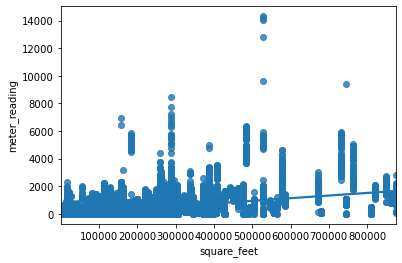

In [34]:
p = sns.regplot(new.square_feet, new.meter_reading)
p

C:\Users\Andri\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='floor_count', ylabel='meter_reading'>

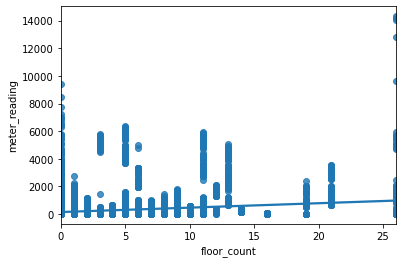

In [35]:
p = sns.regplot(new.floor_count, new.meter_reading)
p

C:\Users\Andri\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year_built', ylabel='meter_reading'>

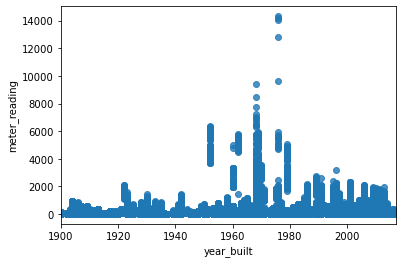

In [36]:
p = sns.regplot(new.year_built, new.meter_reading, )
p

In [37]:
#Logistic Regression

res = ols(formula='year_built ~ square_feet + meter_reading + C(floor_count)', data=new).fit()
print(res.params)
print(res.summary())

Intercept                 1969.107686
C(floor_count)[T.1.0]       -1.038870
C(floor_count)[T.2.0]       -6.539260
C(floor_count)[T.3.0]      -15.718040
C(floor_count)[T.4.0]      -15.232774
C(floor_count)[T.5.0]      -20.547196
C(floor_count)[T.6.0]      -17.287636
C(floor_count)[T.7.0]       -1.257911
C(floor_count)[T.8.0]       -7.900590
C(floor_count)[T.9.0]      -11.915479
C(floor_count)[T.10.0]      12.690469
C(floor_count)[T.11.0]      -1.997669
C(floor_count)[T.12.0]       8.272516
C(floor_count)[T.13.0]     -10.522969
C(floor_count)[T.14.0]      -0.399249
C(floor_count)[T.16.0]      -9.536800
C(floor_count)[T.19.0]      22.348141
C(floor_count)[T.21.0]      -7.651436
C(floor_count)[T.26.0]      -2.308216
square_feet                  0.000005
meter_reading                0.004051
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             year_built   R-squared:                       0.064
Model:                       